### The final is a small project based on a real world dataset. The dataset is a log of geophysical measurements. The goal of this project is to predict p-wave velocity (Vp) based on other geophysical measurements in the well log. 

### Your submission will be include this notebook and a brief report of your results. Your notebook should be organized according to four tasks described below. In addition, please submit a brief report (about a paragraph per task) discussing the choices you made in each section and which factors motivated your decision.

#### Dataset description

Features
--------
Depth:
GR: **Gamma ray**. Shales and clays are derived from rocks that tend to contain naturally occurring radioactive elements, primarily potassium, uranium and thorium. So, they tend to emit more gamma rays.

NPHI: **Neutron porosity** In the field of formation evaluation, porosity is one of the key measurements to quantify oil and gas reserves. Neutron porosity measurement employs a neutron source to measure the hydrogen index in a reservoir, which is directly related to porosity. The Hydrogen Index (HI) of a material is defined as the ratio of the concentration of hydrogen atoms per cm3 in the material, to that of pure water at 75 °F. As hydrogen atoms are present in both water and oil-filled reservoirs, measurement of the amount allows estimation of the amount of liquid-filled porosity.

RHO: **Density**

SW: **Water Saturation** The fraction of water in a given pore space. It is expressed in volume/volume, percent or saturation units. Unless otherwise stated, water saturation is the fraction of formation water in the undisturbed zone. Usually derived from an empirical law (Archie's Law)


VSH: **Volume of Shale** Estimate of the shale fraction based on the Gamma ray plot. 

PHI: **Porosity**

Target
------
Vp: p-wave velocity

### Your tasks

1) Clean the data. We will exclude some features from our data (provided for you below). The data contains Nans which should be removed and the Vp log has an outlier which should be identified and removed.
2) Feature selection. Several features should be removed in the first section (done for you). From there, you are free to choose features as you see fit.
3) Train/test/validation split. The regression target is a 'time series'. Based on your experience in predicting time series from previous lab and homework exercises, choose a sensible split of the training and test data. You may also consider employing a cross validation strategy.
4) Modelling. This is a regression problem. Use simple oridinary least squaress as a benchmark and try to improve results e.g. with regularization (lasso, ridge, etc). Please explore other regression algorithms available in sci-kit learn as well.
5) Model selection and tuning. Once you have established a suitable benchmark in part 4, tune the hyperparameters of your model to try and improve your results. 
6) Prepare the brief report described above. This can be included in a markdown cell in the notebook or submitted in a seperate document.






# Task 1

In [200]:
# Import main libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential

import keras_tuner as kt
from tensorflow import keras
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [201]:
#Read the daata
logs = pd.read_csv('qsiwell2_predict.csv')

#Columns to drop
col_names = ['VS','RHO_OLD','SWX','VPVS','RHOm','RHOf','IP', 'IS', 'ZONE_NUM'] #It is cheating to use VPVS as a feature if you have VS.
logs.drop(col_names, axis=1, inplace=True)

#First row has some empty cells so remove them
logs=logs.iloc[1:,:]

In [202]:
logs.shape

(4116, 8)

<AxesSubplot:xlabel='VP'>

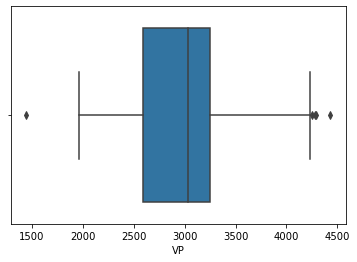

In [203]:
sns.boxplot(x = logs['VP'])

In [204]:
logs.isnull().sum()

DEPTH       0
VP          0
GR          0
NPHI        0
RHO      1415
SW       1415
VSH         0
PHI      1415
dtype: int64

In [205]:
logs = logs.dropna()

<AxesSubplot:xlabel='VP'>

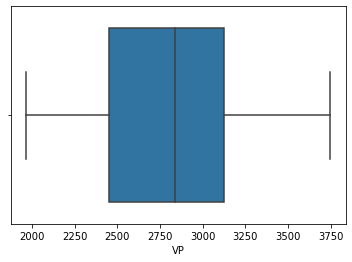

In [206]:
sns.boxplot(x = logs['VP'])

### Task 1 - Observations/Decisions

The box plot of p-wave velocity before and after removing NAN values show that the outliers are automatically removed after removing the NAN values.

# Task 2

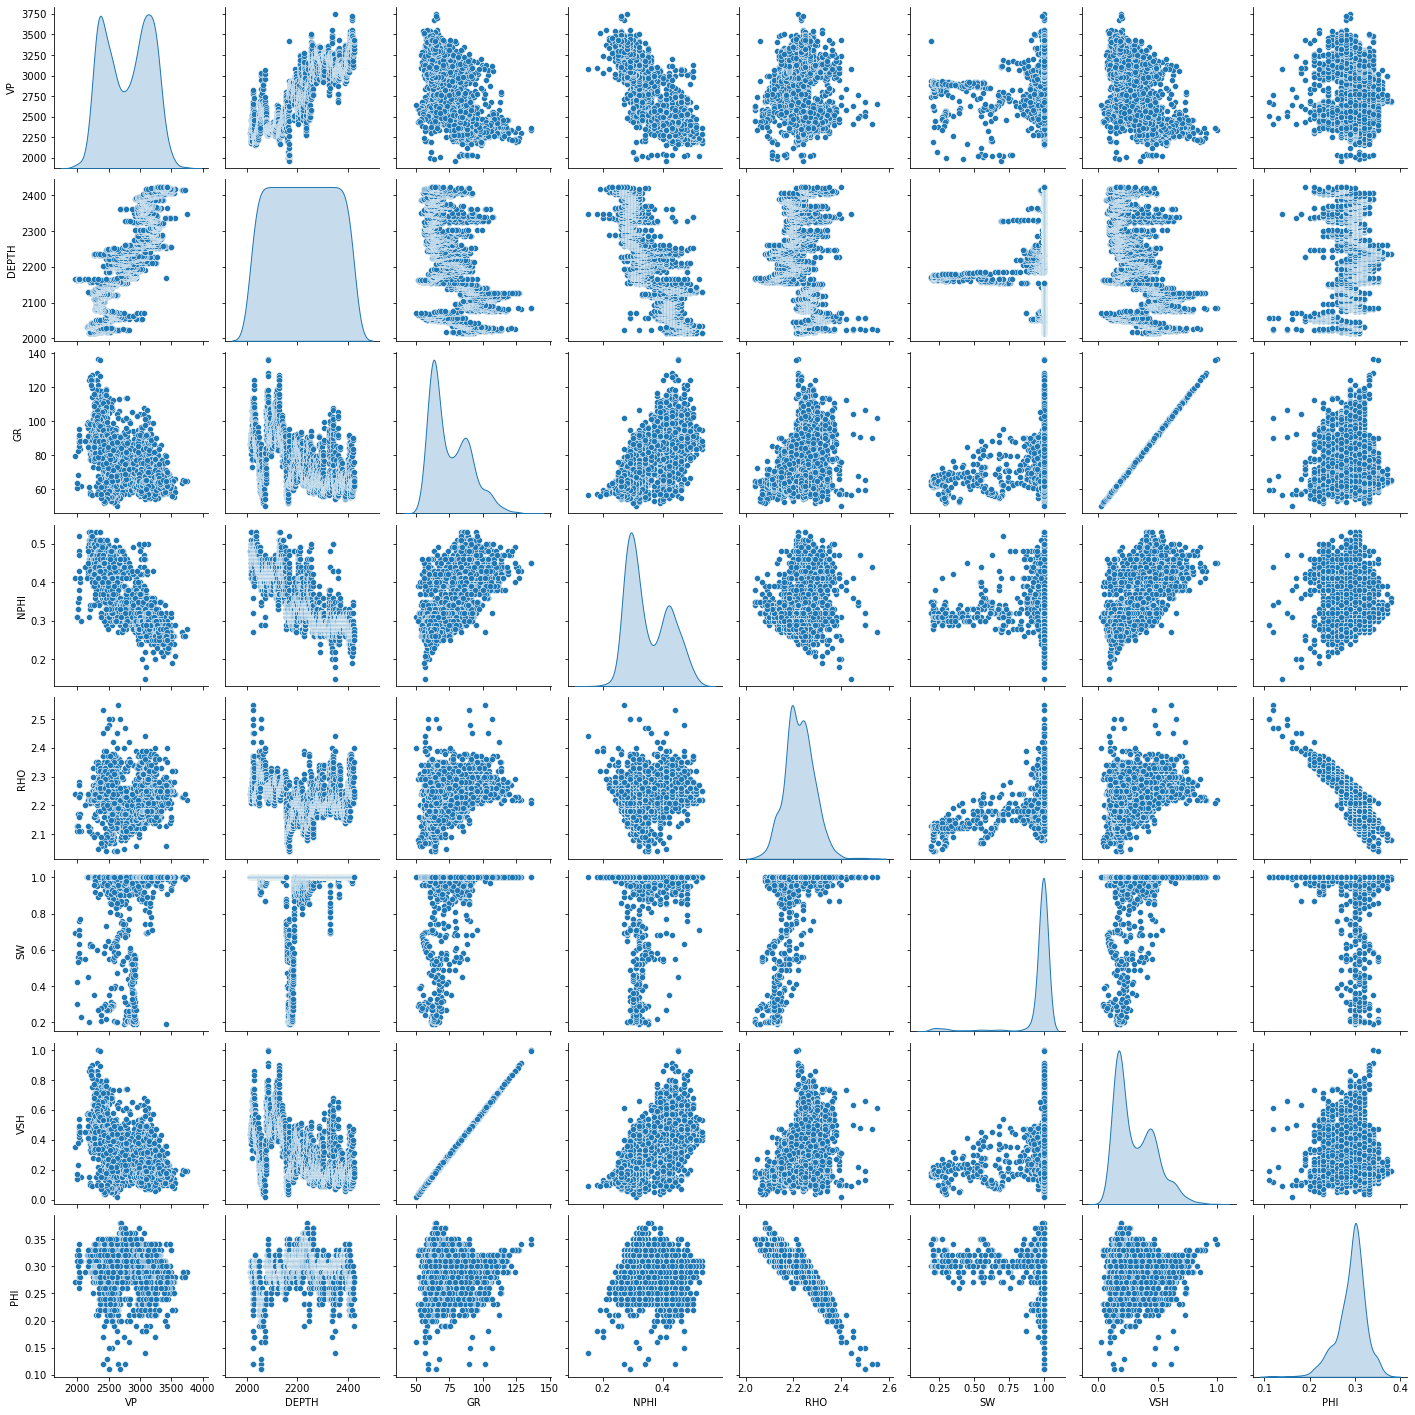

In [207]:
sns.pairplot(logs[['VP', 'DEPTH', 'GR', 'NPHI','RHO','SW','VSH','PHI']], diag_kind='kde')

In [208]:
corr = logs.corr()
corr.style.background_gradient(cmap='coolwarm')

,DEPTH,VP,GR,NPHI,RHO,SW,VSH,PHI
DEPTH,1.000000,0.852623,-0.543687,-0.812849,-0.285614,0.109211,-0.543394,0.176729
VP,0.852623,1.000000,-0.652438,-0.839896,-0.221998,0.064403,-0.652084,0.048545
GR,-0.543687,-0.652438,1.000000,0.701358,0.429566,0.201291,0.999856,-0.087413
NPHI,-0.812849,-0.839896,0.701358,1.000000,0.361965,0.110409,0.700910,-0.143641
RHO,-0.285614,-0.221998,0.429566,0.361965,1.000000,0.443318,0.429597,-0.899215
SW,0.109211,0.064403,0.201291,0.110409,0.443318,1.000000,0.201451,-0.157275
VSH,-0.543394,-0.652084,0.999856,0.700910,0.429597,0.201451,1.000000,-0.087458
PHI,0.176729,0.048545,-0.087413,-0.143641,-0.899215,-0.157275,-0.087458,1.000000


<AxesSubplot:xlabel='PHI', ylabel='Count'>

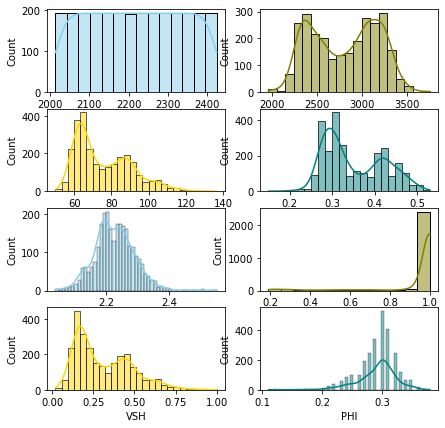

In [209]:
fig, axs = plt.subplots(4, 2, figsize=(7, 7))
sns.histplot(data=logs, x="DEPTH", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=logs, x="VP", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=logs, x="GR", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=logs, x="NPHI", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=logs, x="RHO", kde=True, color="skyblue", ax=axs[2, 0])
sns.histplot(data=logs, x="SW", kde=True, color="olive", ax=axs[2, 1])
sns.histplot(data=logs, x="VSH", kde=True, color="gold", ax=axs[3, 0])
sns.histplot(data=logs, x="PHI", kde=True, color="teal", ax=axs[3, 1])

In [210]:
#Percentage of SW values which are equal to 1
(logs.SW ==1).mean()*100

#Drop SW which is equal to 1 for around 80% of the data
#Drop GR since it is exactly correlated with the shale volume (VSH)
logs.drop(['SW','GR'], axis=1, inplace=True)

In [211]:
logs.describe()

,DEPTH,VP,NPHI,RHO,VSH,PHI
count,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000
mean,2219.145202,2803.502814,0.350903,2.225198,0.308726,0.291910
std,118.850036,366.902308,0.070512,0.061964,0.168485,0.032364
min,2013.410000,1964.700000,0.150000,2.040000,0.020000,0.110000
25%,2116.280000,2452.700000,0.290000,2.190000,0.170000,0.280000
50%,2219.150000,2839.900000,0.330000,2.220000,0.260000,0.300000
75%,2322.020000,3125.200000,0.410000,2.260000,0.440000,0.310000
max,2424.890000,3747.500000,0.530000,2.550000,1.000000,0.380000


### Task 2 - Observations/Decisions

1. Dropped Water Saturation since 80% of its values were 1. It doesn’t seem to be a good predictor of p-wave velocity with the given data. This is verified by comparing the performance of the linear regression with and without water saturation
2. From the correlation plots, it is clear that Gamma Ray (GR) is exactly correlated with the Shale Volume (VSH). To avoid repetition of the information, dropped Gamma Ray

# Task 3 

In [212]:
VP = logs.pop('VP')
logs.insert(5, 'VP', VP)

In [213]:
logs.head()

,DEPTH,NPHI,RHO,VSH,PHI,VP
1,2013.41,0.48,2.24,0.44,0.29,2296.7
2,2013.56,0.45,2.24,0.43,0.29,2290.4
3,2013.71,0.41,2.24,0.44,0.29,2277.5
4,2013.86,0.43,2.24,0.48,0.30,2262.0
5,2014.01,0.47,2.24,0.51,0.30,2263.1


In [214]:
logs = logs.values
X, y = logs[:,:-1], logs[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [215]:
trans =RobustScaler()
X_train = trans.fit_transform(X_train)
X_test = trans.transform(X_test)

In [216]:
trans =RobustScaler()
y_train = trans.fit_transform(y_train.reshape(-1,1))
y_test = trans.transform(y_test.reshape(-1,1))

### Task 3 - Observations/Decisions
1. The dataset is randomly divided into 80% training and 20% testing data points
2. The features in the given dataset have different ranges. Therefore, feature scaling is essential. The distrbiutions of the features in the given data are highly skewed and also contain outliers as evident from their histograms. The standardized scalar is sensitive to skewed distribution. Therefore robust scaler is used for feature scaling since it is robust to outliers and skewed distribution. 
3. The target variable is also scaled to be able to use neural network for regression analysis

# Task 4

## Some Functions

In [217]:
def model_performance(y_test,X_test, model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return y_pred,mse

def plot_true_predicted(y_test,y_pred, lims):
    a = plt.axes(aspect='equal')
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values [VP]')
    plt.ylabel('Predictions [VP]')
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

## Linear Regression

MSE score: 0.0494


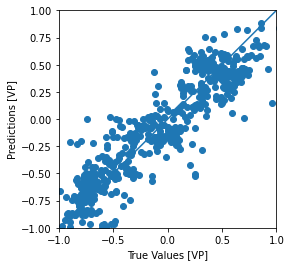

In [218]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
y_pred,mse = model_performance(y_test,X_test,regr)
print("MSE score: %.4f" % mse)
plot_true_predicted(y_test,y_pred, [-1,1])

## Lasso Grid Search

In [219]:
lassoregr = linear_model.Lasso()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(lassoregr, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
results = search.fit(X_train,y_train)
print('R2_Score: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

R2_Score: -0.055
Config: {'alpha': 0.0}


/Users/animeshrastogi/miniforge3/envs/env_tf/lib/python3.8/site-packages/sklearn/model_selection/_search.py:926: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/Users/animeshrastogi/miniforge3/envs/env_tf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/animeshrastogi/miniforge3/envs/env_tf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.895e+01, tolerance: 6.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one

## Ridge Grid Search

In [220]:
ridgeregrr = linear_model.Ridge()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(ridgeregrr, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
results = search.fit(X_train,y_train)
print('MSE: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)

MSE: -0.05490
Config: {'alpha': 0.99}


Mean squared error: 0.0493


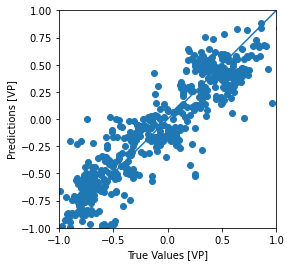

In [221]:
regr = linear_model.Ridge(alpha = 0.99)
regr.fit(X_train,y_train)
y_pred,mse = model_performance(y_test,X_test,regr)
print("Mean squared error: %.4f" % mse)
plot_true_predicted(y_test,y_pred, [-1,1])

## Neural Network

In [230]:
model = Sequential()
model.add(Dense(50, input_dim=5, kernel_initializer='normal',activation='sigmoid'))
model.add(Dense(units = 50, activation = 'sigmoid'))
model.add(Dense(units = 50, activation = 'sigmoid'))
model.add(Dense(units =1))
model.compile(optimizer = 'adam',loss = 'mean_squared_error',metrics=['mse'])
history = model.fit(X_train, y_train, batch_size = 2, epochs = 10,validation_split=0.2)
y_pred,mse = model_performance(y_test,X_test,model)
print("Mean squared error: %.4f" % mse)

Epoch 1/10
 51/864 [>.............................] - ETA: 2s - loss: 0.4393 - mse: 0.4393

2021-12-04 18:38:59.145939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


852/864 [============================>.] - ETA: 0s - loss: 0.1560 - mse: 0.1560

2021-12-04 18:39:01.929264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


864/864 [==============================] - 3s 4ms/step - loss: 0.1552 - mse: 0.1552 - val_loss: 0.0921 - val_mse: 0.0921
Epoch 2/10
864/864 [==============================] - 3s 3ms/step - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0556 - val_mse: 0.0556
Epoch 3/10
864/864 [==============================] - 3s 3ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 0.0566 - val_mse: 0.0566
Epoch 4/10
864/864 [==============================] - 3s 3ms/step - loss: 0.0561 - mse: 0.0561 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 5/10
864/864 [==============================] - 3s 3ms/step - loss: 0.0559 - mse: 0.0559 - val_loss: 0.0540 - val_mse: 0.0540
Epoch 6/10
864/864 [==============================] - 3s 3ms/step - loss: 0.0548 - mse: 0.0548 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 7/10
864/864 [==============================] - 3s 3ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0739 - val_mse: 0.0739
Epoch 8/10
864/864 [==============================] - 3s 3ms/step - loss: 0.0526 - mse:

2021-12-04 18:39:28.367645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


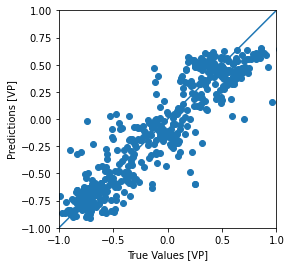

In [231]:
plot_true_predicted(y_test,y_pred, [-1,1])
plt.show()

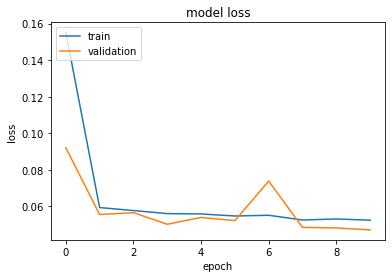

In [234]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Decision Tree Regressor

Mean squared error: 0.0239


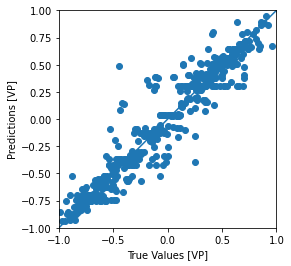

In [262]:
regr_1 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(X_train, y_train)
y_pred,mse = model_performance(y_test,X_test,regr_1)
print("Mean squared error: %.4f" % mse)
plot_true_predicted(y_test,y_pred, [-1,1])

### Task 4 - Observations/Decisions

We use five regression algorithms on the given dataset to predict the p-wave velocity.

1. Linear Regression fits the data reasonably well
2. Hyperparameter tuning is performed to find the best value of alpha in both lasso and ridge regression. However, both the algorithms couldn't improve the performance of the Linear Regression 
3. The neural network is trained with three hidden layers with 50 neurons each. The neural network improved the performance of the model when compared with the Linear Regression
4. A decision tree regressor is applied to train the data. Decision tree further improves the model performance when compared to neural network and linear regression. One of the reasons might be that the decision tree is robust to outliers in the input features
5. Decision Tree and Neural Network are chosen for hyperparameter tuning in Task 5

# Task 5

In [236]:
def build_model(hp):
  model = Sequential()

  model.add(Dense(hp.Int('units1', min_value=10,max_value = 100, step = 10),
     activation=hp.Choice('dense_activation1',values=['relu', 'tanh', 'sigmoid'])))
  model.add(Dense(hp.Int('units2', min_value=10,max_value = 100, step = 10),
      activation=hp.Choice('dense_activation2',values=['relu', 'tanh', 'sigmoid'])))
  model.add(Dense(hp.Int('units3', min_value=10,max_value = 100, step = 10),
      activation=hp.Choice('dense_activation3',values=['relu', 'tanh', 'sigmoid'])))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.add(Dense(1))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['accuracy'])

  return model

In [239]:
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

tuner.search(X_train, y_train, epochs=10,validation_split=0.2)

Trial 30 Complete [00h 00m 03s]
val_loss: 0.03855337202548981

Best val_loss So Far: 0.03855337202548981
Total elapsed time: 00h 00m 50s
INFO:tensorflow:Oracle triggered exit


In [240]:
best_model = tuner.get_best_models()[0]
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units1')}, 
second densely-connected layer is {best_hps.get('units2')}, an d
third densely-connected layer is {best_hps.get('units3')}. The optimal activation function for the 
first densely-connected layer is {best_hps.get('dense_activation1')}, 
second densely-connected layer is {best_hps.get('dense_activation2')}, 
third densely-connected layer is {best_hps.get('dense_activation3')}. 

The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 50, 
second densely-connected layer is 30, an d
third densely-connected layer is 40. The optimal activation function for the 
first densely-connected layer is relu, 
second densely-connected layer is sigmoid, 
third densely-connected layer is tanh. 

The optimal learning rate for the optimizer
is 0.01.



Mean squared error: 0.0361


2021-12-04 18:42:31.627799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


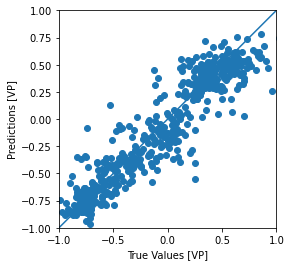

In [241]:
best_model
y_pred,mse = model_performance(y_test,X_test,best_model)
print("Mean squared error: %.4f" % mse)
plot_true_predicted(y_test,y_pred, [-1,1])

In [242]:
mse_all = []
for m in range(1,20):
    regr_1 = DecisionTreeRegressor(max_depth=m)
    regr_1.fit(X_train, y_train)
    y_pred,mse = model_performance(y_test,X_test,regr_1)
    mse_all.append(mse)

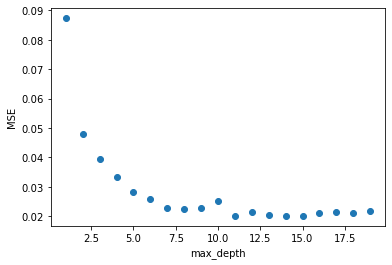

0.0205099552239796


In [246]:
m = np.linspace(1, 19, num=19)
plt.scatter(m,mse_all)
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.show()
print(mse_all[12])

### Task 5 - Observations/Decisions

1. Hyperparameter tuning is performed in the neural network using the keras-tuner. The results return the optimal model in the given range of hyperparameters. The optimal model has a mean-squared error of 0.0361. 
2. Hyperparameter tuning is performed to improve the accuracy of the decision tree. Results show that, for max_depth>12, the model performance does not improve much

### Conclusion

Decision Tree Regression with max_depth = 12 performs the best to predict the p-wave velocity for the given data-set. The MSE is 0.0205 which is minumum among all the models trained.

## References

1. https://www.tensorflow.org/tutorials/keras/keras_tuner
2. https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/